In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

In [3]:
def extract_features_spectrogram(file_path, duration=4):
    try:
        audio, sr = tf.audio.decode_wav(tf.io.read_file(file_path), desired_channels=1)
        print("Audio Tensor Shape after decoding:", audio.shape)
        
        audio = tf.squeeze(audio, axis=-1)
        audio = tf.cast(audio, tf.float32)

        spectrogram = tf.signal.stft(audio, frame_length=1024, frame_step=512, fft_length=1024)
        spectrogram = tf.abs(spectrogram)
        
        return spectrogram
    
    except tf.errors.InvalidArgumentError:
        print(f"Invalid WAV file: {file_path}. Skipping this file.")
        return None

In [10]:
def preprocess_data(data):
    features = []
    labels = []
    max_shape = (0, 0)
    
    for index, row in data.iterrows():
        file_path = os.path.join('UrbanSound8K', 'fold' + str(row['fold']), row['slice_file_name'])
        if(os.path.exists(file_path)):
            feature = extract_features_spectrogram(file_path)
        
            if feature is None:
                continue
            
            max_shape = (max(max_shape[0], feature.shape[0]), max(max_shape[1], feature.shape[1]))
            
            features.append(feature)
            labels.append(row['classID'])
    
    padded_features = []
    for arr in features:
        pad_width = ((0, max_shape[0] - arr.shape[0]), (0, max_shape[1] - arr.shape[1]))
        padded_arr = np.pad(arr, pad_width, mode='constant')
        padded_features.append(padded_arr)
    
    return padded_features, labels


Audio Tensor Shape after decoding: (99225, 1)


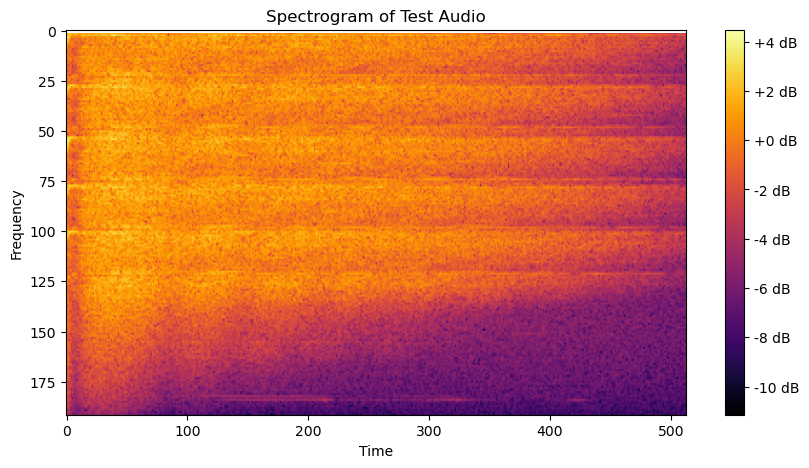

In [11]:
file_path = 'UrbanSound8K\\fold1\\7061-6-0-0.wav'

feat = extract_features_spectrogram(file_path)
plt.figure(figsize=(10, 5))
plt.imshow(tf.math.log(feat).numpy(), aspect='auto', cmap='inferno')
plt.title('Spectrogram of Test Audio')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.colorbar(format='%+2.0f dB')
plt.show()

In [12]:
metadata = pd.read_csv('UrbanSound8K.csv')

In [13]:
features, labels = preprocess_data(metadata)

Audio Tensor Shape after decoding: (28600, 1)
Audio Tensor Shape after decoding: (46305, 1)
Audio Tensor Shape after decoding: (17875, 1)
Audio Tensor Shape after decoding: (71442, 1)
Audio Tensor Shape after decoding: (82026, 1)
Audio Tensor Shape after decoding: (176400, 1)
Audio Tensor Shape after decoding: (176400, 1)
Audio Tensor Shape after decoding: (176400, 1)
Audio Tensor Shape after decoding: (176400, 1)
Audio Tensor Shape after decoding: (176400, 1)
Audio Tensor Shape after decoding: (176400, 1)
Audio Tensor Shape after decoding: (176400, 1)
Audio Tensor Shape after decoding: (176400, 1)
Audio Tensor Shape after decoding: (192000, 1)
Audio Tensor Shape after decoding: (192000, 1)
Audio Tensor Shape after decoding: (192000, 1)
Audio Tensor Shape after decoding: (192000, 1)
Audio Tensor Shape after decoding: (192000, 1)
Audio Tensor Shape after decoding: (192000, 1)
Audio Tensor Shape after decoding: (192000, 1)
Audio Tensor Shape after decoding: (192000, 1)
Audio Tensor Shape

In [14]:
X = np.array(features)
y = np.array(labels)

In [15]:
X = (X - np.mean(X)) / np.std(X)

label_encoder = LabelEncoder()
y = to_categorical(label_encoder.fit_transform(y))

In [16]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = X_train[..., np.newaxis]
X_val = X_val[..., np.newaxis]

In [17]:
input_shape = X_train.shape[1:]
num_classes = y_train.shape[1]

In [18]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 749, 513, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 374, 256, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 374, 256, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 187, 128, 64)     0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 187, 128, 128)     73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 93, 64, 128)      0

In [20]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/10
42/42 [==============================] - 310s 7s/step - loss: 1.9137 - accuracy: 0.4326 - val_loss: 1.1988 - val_accuracy: 0.6138
Epoch 2/10
42/42 [==============================] - 307s 7s/step - loss: 0.9455 - accuracy: 0.6871 - val_loss: 0.9461 - val_accuracy: 0.7036
Epoch 3/10
42/42 [==============================] - 300s 7s/step - loss: 0.5639 - accuracy: 0.8159 - val_loss: 0.9298 - val_accuracy: 0.7665
Epoch 4/10
42/42 [==============================] - 289s 7s/step - loss: 0.4656 - accuracy: 0.8600 - val_loss: 1.0451 - val_accuracy: 0.7844
Epoch 5/10
42/42 [==============================] - 283s 7s/step - loss: 0.3585 - accuracy: 0.8982 - val_loss: 1.4195 - val_accuracy: 0.7455
Epoch 6/10
42/42 [==============================] - 279s 7s/step - loss: 0.2255 - accuracy: 0.9334 - val_loss: 1.6333 - val_accuracy: 0.7395
Epoch 7/10
42/42 [==============================] - 278s 7s/step - loss: 0.1840 - accuracy: 0.9513 - val_loss: 1.6096 - val_accuracy: 0.7844
Epoch 8/10
42

In [21]:
loss, accuracy = model.evaluate(X_val, y_val)
print("Accuracy:", accuracy)

11/11 [==============================] - 15s 1s/step - loss: 1.6490 - accuracy: 0.7784
Accuracy: 0.7784430980682373


In [22]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

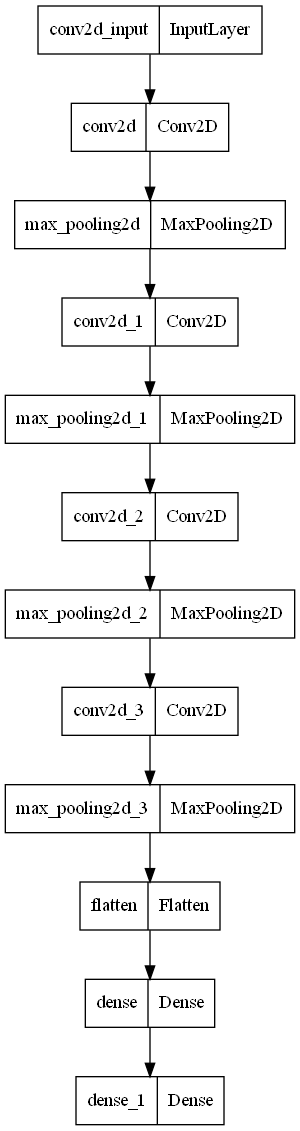

In [23]:
import pydot
from keras.utils import plot_model

plot_model(model, to_file='cnn_audio_stft.png')


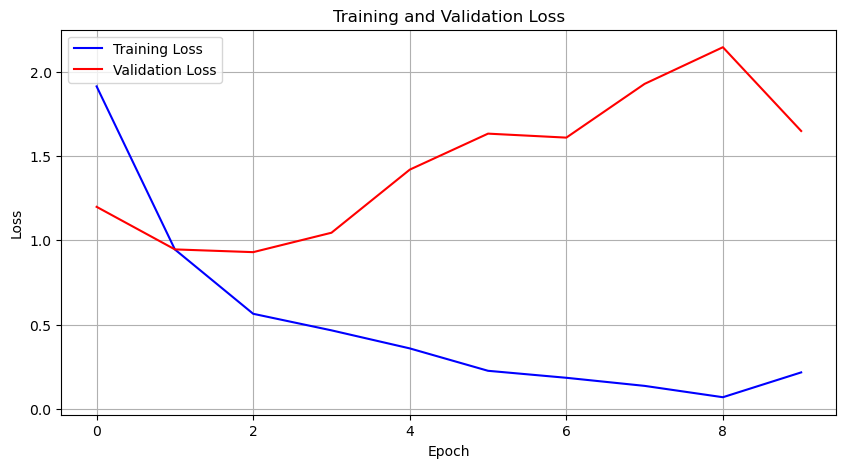

In [24]:
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Training Loss', color='blue')
plt.plot(val_loss, label='Validation Loss', color='red')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()